# Exploratory Data Analysis: Flickr30k Dataset

This notebook performs exploratory data analysis on the [nlphuji/flickr30k](https://huggingface.co/datasets/nlphuji/flickr30k) dataset from Hugging Face, which contains images paired with descriptive captions.

## Setup and Installation

First, let's install the necessary packages for our analysis.

In [31]:
# Install required packages (removed tqdm and ipywidgets)
!pip install datasets matplotlib seaborn pandas numpy pillow wordcloud nltk transformers

In [33]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from PIL import Image
from collections import Counter
import re
import random
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import time

# Simple progress reporting function instead of tqdm
def process_with_progress(iterable, desc="Processing", sample_rate=0.1):
    total = len(iterable)
    print(f"{desc}: 0/{total} (0.0%)")
    start_time = time.time()
    
    for i, item in enumerate(iterable):
        # Report progress only occasionally to avoid flooding output
        if i == 0 or i == total-1 or i % max(1, int(total * sample_rate)) == 0:
            elapsed = time.time() - start_time
            print(f"{desc}: {i+1}/{total} ({(i+1)/total*100:.1f}%) - {elapsed:.1f}s elapsed")
        yield item
    
    print(f"{desc} complete. Total time: {time.time() - start_time:.1f}s")

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreadellacorte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreadellacorte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading the Dataset

Now let's load the Flickr30k dataset from Hugging Face.

In [27]:
# Load the Flickr30k dataset
dataset = load_dataset("nlphuji/flickr30k")
print(f"Dataset structure: {dataset}")

# Check what splits are actually available in the dataset
print(f"Available splits: {list(dataset.keys())}")

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})
Available splits: ['test']


In [34]:
# Determine the main split name (might be 'train' or just 'default' or something else)
main_split = list(dataset.keys())[0]  # Use the first split available
print(f"Using split: '{main_split}'")

# Let's examine the first few examples to understand the structure
dataset[main_split][:5]

Using split: 'test'


{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>],
 'caption': [['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
   'Two young, White males are outside near many bushes.',
   'Two men in green shirts are standing in a yard.',
   'A man in a blue shirt standing in a garden.',
   'Two friends enjoy time spent together.'],
  ['Several men in hard hats are operating a giant pulley system.',
   'Workers look down from up above on a piece of equipment.',
   'Two men working on a machine wearing hard hats.',
   'Four men on top of a tall structure.',
   'Three men on a large rig.'],
  ['A child in a pink dress is climbing up a set of stairs in an entry way.',
   'A l

## Basic Dataset Exploration

Let's get some basic information about the dataset.

In [35]:
# Let's check the size of each split
for split in dataset.keys():
    print(f"{split} set size: {len(dataset[split])}")

# Check the columns/features available in the dataset
print(f"\nColumns in the dataset: {dataset[main_split].column_names}")

test set size: 31014

Columns in the dataset: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename']


## Image Analysis

Let's examine the images in the dataset.

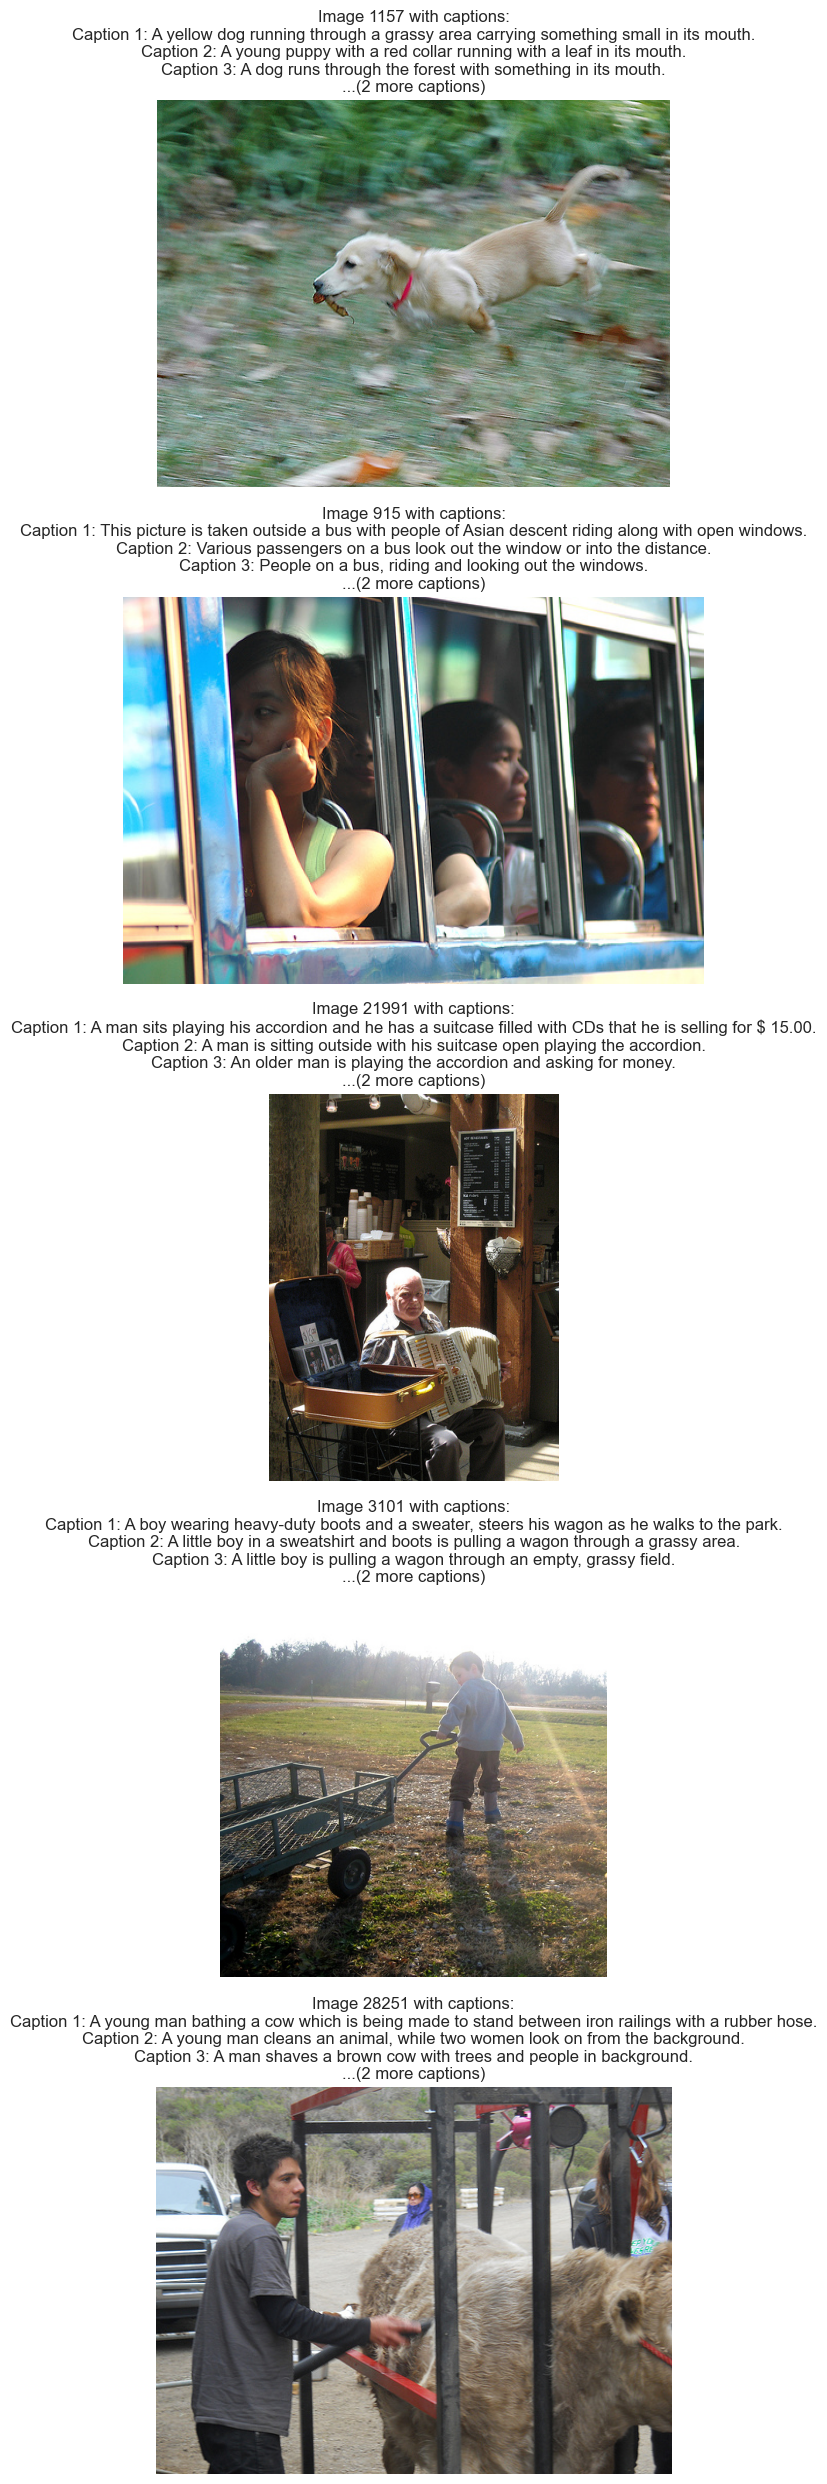

In [36]:
# Function to display images with their captions
def display_images_with_captions(dataset, indices, max_captions=3):
    n = len(indices)
    fig, axes = plt.subplots(n, 1, figsize=(15, 5*n))
    if n == 1:
        axes = [axes]  # Make it iterable for a single image
        
    for i, idx in enumerate(indices):
        example = dataset[idx]
        image = example['image']
        captions = example['caption']
        
        axes[i].imshow(image)
        axes[i].axis('off')
        
        # Display up to max_captions captions
        title = f"Image {idx} with captions:\n"
        for j, caption in enumerate(captions[:max_captions]):
            title += f"Caption {j+1}: {caption}\n"
        if len(captions) > max_captions:
            title += f"...({len(captions) - max_captions} more captions)"
            
        axes[i].set_title(title, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Display a few random images with their captions
random_indices = random.sample(range(len(dataset[main_split])), 5)
display_images_with_captions(dataset[main_split], random_indices)

Processing 1000 images...
Progress: 100/1000 (10.0%) - 0.7s elapsed
Progress: 100/1000 (10.0%) - 0.7s elapsed
Progress: 200/1000 (20.0%) - 1.3s elapsed
Progress: 200/1000 (20.0%) - 1.3s elapsed
Progress: 300/1000 (30.0%) - 1.9s elapsed
Progress: 300/1000 (30.0%) - 1.9s elapsed
Progress: 400/1000 (40.0%) - 2.6s elapsed
Progress: 400/1000 (40.0%) - 2.6s elapsed
Progress: 500/1000 (50.0%) - 3.2s elapsed
Progress: 500/1000 (50.0%) - 3.2s elapsed
Progress: 600/1000 (60.0%) - 3.7s elapsed
Progress: 600/1000 (60.0%) - 3.7s elapsed
Progress: 700/1000 (70.0%) - 4.5s elapsed
Progress: 700/1000 (70.0%) - 4.5s elapsed
Progress: 800/1000 (80.0%) - 5.3s elapsed
Progress: 800/1000 (80.0%) - 5.3s elapsed
Progress: 900/1000 (90.0%) - 5.9s elapsed
Progress: 900/1000 (90.0%) - 5.9s elapsed
Progress: 1000/1000 (100.0%) - 6.4s elapsed
Processing complete. Total time: 6.4s
Progress: 1000/1000 (100.0%) - 6.4s elapsed
Processing complete. Total time: 6.4s


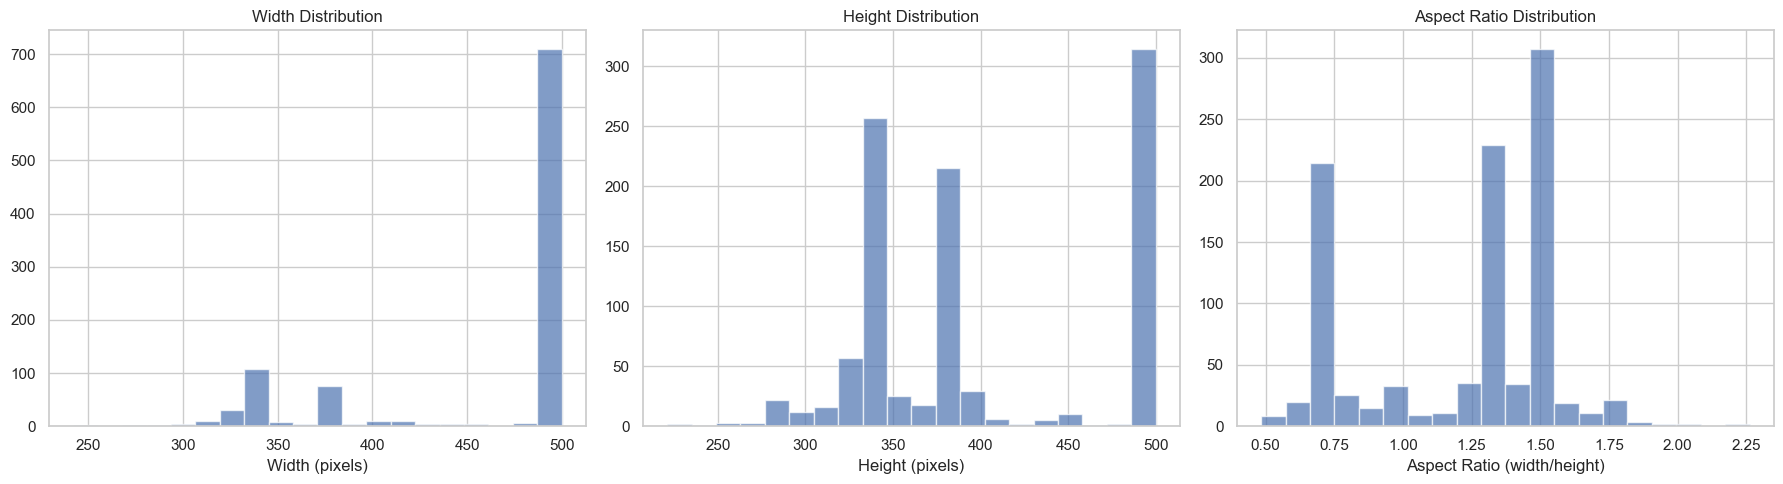

Width: min=242, max=500, mean=458.06, median=500.0
Height: min=221, max=500, mean=397.86, median=375.0
Aspect Ratio: min=0.48, max=2.26, mean=1.22, median=1.33


In [37]:
# Analyze image sizes without using tqdm
def get_image_sizes(dataset, num_samples=1000):
    widths = []
    heights = []
    aspects = []
    
    # Use fewer samples for efficiency
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    print(f"Processing {len(indices)} images...")
    start_time = time.time()
    
    # Process in batches and report progress
    batch_size = max(1, len(indices) // 10)  # report progress ~10 times
    
    for i, idx in enumerate(indices):
        img = dataset[idx]['image']
        width, height = img.size
        aspect = width / height
        
        widths.append(width)
        heights.append(height)
        aspects.append(aspect)
        
        # Report progress periodically
        if (i + 1) % batch_size == 0 or i == len(indices) - 1:
            progress = (i + 1) / len(indices) * 100
            elapsed = time.time() - start_time
            print(f"Progress: {i+1}/{len(indices)} ({progress:.1f}%) - {elapsed:.1f}s elapsed")
    
    print(f"Processing complete. Total time: {time.time() - start_time:.1f}s")
    return widths, heights, aspects

widths, heights, aspects = get_image_sizes(dataset[main_split])

# Plot image size distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(widths, bins=20, alpha=0.7)
axes[0].set_title('Width Distribution')
axes[0].set_xlabel('Width (pixels)')

axes[1].hist(heights, bins=20, alpha=0.7)
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (pixels)')

axes[2].hist(aspects, bins=20, alpha=0.7)
axes[2].set_title('Aspect Ratio Distribution')
axes[2].set_xlabel('Aspect Ratio (width/height)')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}, median={np.median(widths)}")
print(f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}, median={np.median(heights)}")
print(f"Aspect Ratio: min={min(aspects):.2f}, max={max(aspects):.2f}, mean={np.mean(aspects):.2f}, median={np.median(aspects):.2f}")

## Caption Analysis

Let's analyze the captions in the dataset.

In [43]:
# Function to get all captions from the dataset without using tqdm
def get_all_captions(dataset_split, max_samples=1000):
    all_captions = []
    
    print(f"Dataset info: {type(dataset_split)}")
    # Print information about the dataset structure
    print(f"Dataset features: {dataset_split.features if hasattr(dataset_split, 'features') else 'No features attribute'}")
    
    # Limit the number of examples to process for efficiency
    total = min(max_samples, len(dataset_split))
    print(f"Processing captions from {total} examples...")
    start_time = time.time()
    
    # Proper way to iterate through samples in a Hugging Face dataset
    samples = list(dataset_split.take(total))
    
    # Process in batches for reporting progress
    batch_size = max(1, total // 10)  # report progress ~10 times
    
    for i, example in enumerate(samples):
        try:
            # Most datasets have a 'caption' field
            if 'caption' in example:
                captions = example['caption']
                if isinstance(captions, list):
                    all_captions.extend(captions)
                else:
                    all_captions.append(captions)
            else:
                # If no caption field, print what fields are available to debug
                if i == 0:  # Only print once
                    print(f"Warning: No 'caption' field found. Available fields: {list(example.keys())}")
        except Exception as e:
            print(f"Error processing item {i}: {e}")
            if i == 0:  # If first item fails, print its structure
                print(f"First item structure: {example}")
        
        # Report progress periodically
        if (i + 1) % batch_size == 0 or i == total - 1:
            progress = (i + 1) / total * 100
            elapsed = time.time() - start_time
            print(f"Progress: {i+1}/{total} ({progress:.1f}%) - {elapsed:.1f}s elapsed")
    
    print(f"Caption processing complete. Total time: {time.time() - start_time:.1f}s")
    return all_captions

# Get captions using a small sample first to verify it works
print(f"Available dataset splits: {list(dataset.keys())}")
max_samples = 50  # Start with a small number to test

# Pass the dataset split directly without slicing
train_captions = get_all_captions(dataset[main_split], max_samples=max_samples)

# Display caption info
print(f"Total number of captions sampled: {len(train_captions)}")
if train_captions:
    print(f"First 5 captions:\n")
    for i, caption in enumerate(train_captions[:5]):
        print(f"{i+1}. {caption}")
else:
    print("No captions found.")

Available dataset splits: ['test']
Dataset info: <class 'datasets.arrow_dataset.Dataset'>
Dataset features: {'image': Image(mode=None, decode=True, id=None), 'caption': [Value(dtype='string', id=None)], 'sentids': [Value(dtype='string', id=None)], 'split': Value(dtype='string', id=None), 'img_id': Value(dtype='string', id=None), 'filename': Value(dtype='string', id=None)}
Processing captions from 50 examples...
Progress: 5/50 (10.0%) - 0.3s elapsed
Progress: 10/50 (20.0%) - 0.3s elapsed
Progress: 15/50 (30.0%) - 0.3s elapsed
Progress: 20/50 (40.0%) - 0.3s elapsed
Progress: 25/50 (50.0%) - 0.3s elapsed
Progress: 30/50 (60.0%) - 0.3s elapsed
Progress: 35/50 (70.0%) - 0.3s elapsed
Progress: 40/50 (80.0%) - 0.3s elapsed
Progress: 45/50 (90.0%) - 0.3s elapsed
Progress: 50/50 (100.0%) - 0.3s elapsed
Caption processing complete. Total time: 0.3s
Total number of captions sampled: 250
First 5 captions:

1. Two young guys with shaggy hair look at their hands while hanging out in the yard.
2. Two

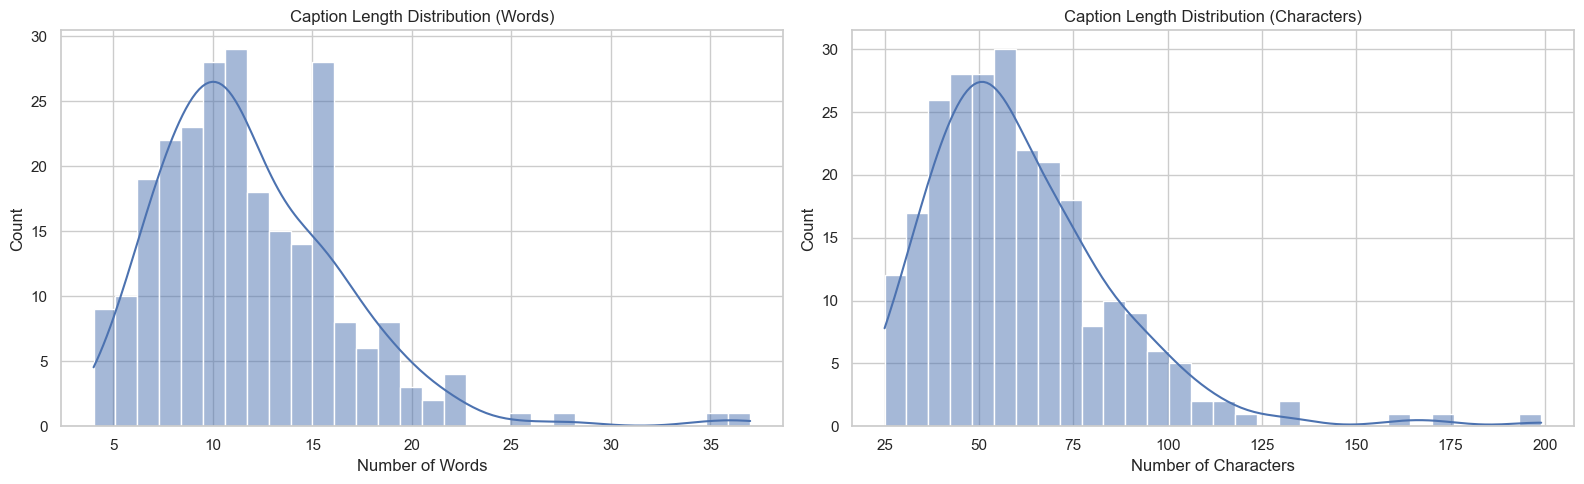

Caption Word Count: min=4, max=37, mean=11.88, median=11.0
Caption Character Count: min=25, max=199, mean=61.27, median=56.0


In [44]:
# Analyze caption lengths
caption_lengths = [len(caption.split()) for caption in train_captions]
caption_char_lengths = [len(caption) for caption in train_captions]

# Plot caption length distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(caption_lengths, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Caption Length Distribution (Words)')
axes[0].set_xlabel('Number of Words')

sns.histplot(caption_char_lengths, bins=30, kde=True, ax=axes[1])
axes[1].set_title('Caption Length Distribution (Characters)')
axes[1].set_xlabel('Number of Characters')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Caption Word Count: min={min(caption_lengths)}, max={max(caption_lengths)}, mean={np.mean(caption_lengths):.2f}, median={np.median(caption_lengths)}")
print(f"Caption Character Count: min={min(caption_char_lengths)}, max={max(caption_char_lengths)}, mean={np.mean(caption_char_lengths):.2f}, median={np.median(caption_char_lengths)}")

## Word Frequency Analysis

Let's analyze the most common words in the captions.

Most common words in captions:
[('a', 433), ('in', 131), ('man', 93), ('the', 84), ('on', 78), ('and', 63), ('with', 62), ('of', 61), ('is', 50), ('at', 33), ('are', 32), ('two', 31), ('white', 29), ('standing', 26), ('to', 26), ('dog', 24), ('wearing', 23), ('black', 22), ('people', 22), ('young', 21)]


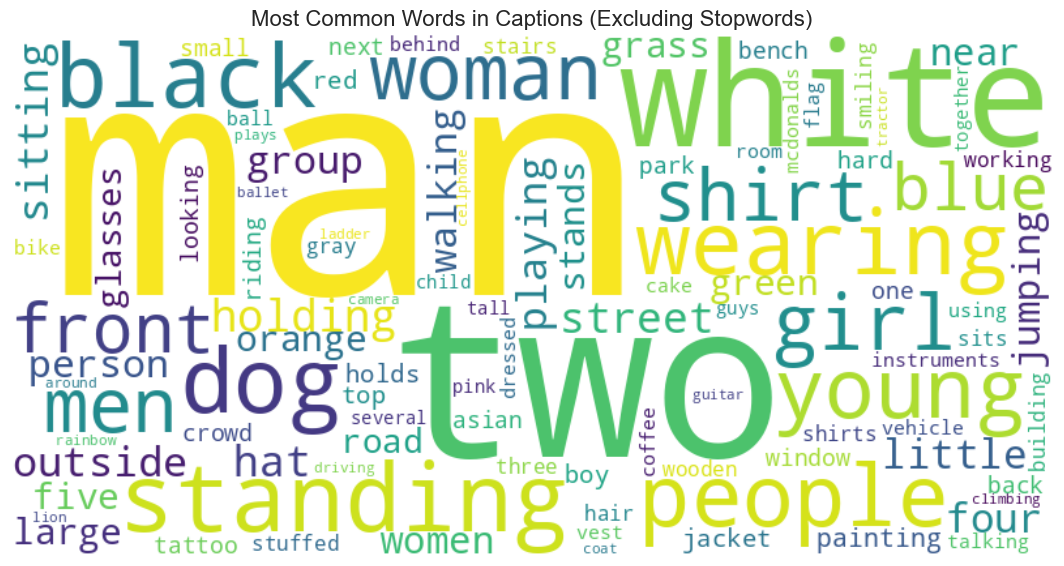

In [45]:
# Tokenize all captions and count word frequencies
def get_word_frequencies(captions):
    # Join all captions and split by space to get words
    all_words = []
    for caption in captions:
        # Convert to lowercase and remove punctuation
        clean_caption = re.sub(r'[^\w\s]', '', caption.lower())
        words = clean_caption.split()
        all_words.extend(words)
    
    # Count word frequencies
    word_freq = Counter(all_words)
    return word_freq

word_frequencies = get_word_frequencies(train_captions)

# Display the most common words
print("Most common words in captions:")
print(word_frequencies.most_common(20))

# Create a word cloud visualization
stop_words = set(stopwords.words('english'))

# Filter out stopwords for a more meaningful visualization
filtered_word_freq = {word: freq for word, freq in word_frequencies.items() 
                     if word not in stop_words and len(word) > 2}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, 
                     background_color='white').generate_from_frequencies(filtered_word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Captions (Excluding Stopwords)', fontsize=16)
plt.show()

## Captions per Image Analysis

Let's check how many captions are associated with each image.

Analyzing captions per image for 100 samples...
Analysis complete. Total time: 0.8s
Analysis complete. Total time: 0.8s


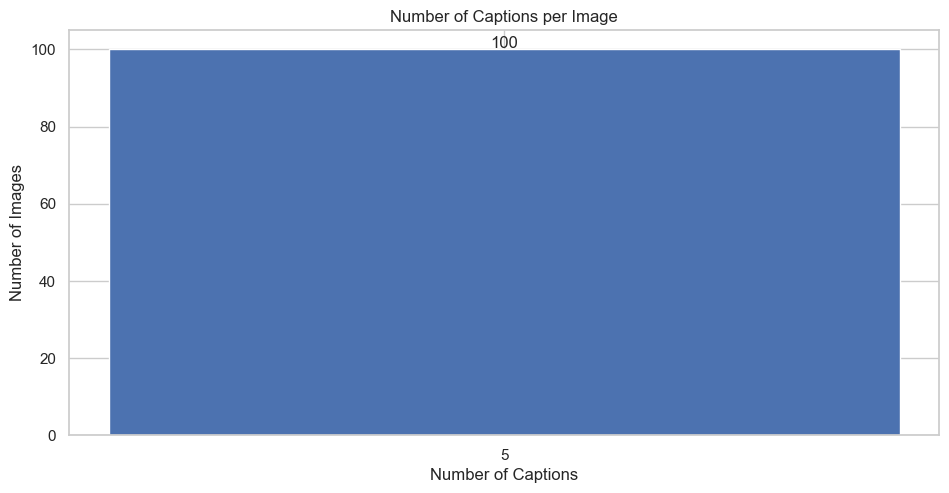

Caption counts per image: {5: 100}
Average captions per image: 5.0


In [49]:
# Count the number of captions per image
def count_captions_per_image(dataset_split, max_samples=1000):
    caption_counts = []
    
    # Get a subset of examples using the take() method
    total = min(max_samples, len(dataset_split))
    print(f"Analyzing captions per image for {total} samples...")
    start_time = time.time()
    
    # Proper way to iterate through samples in a Hugging Face dataset
    samples = list(dataset_split.take(total))
    
    for example in samples:
        if 'caption' in example:
            captions = example['caption']
            if isinstance(captions, list):
                caption_counts.append(len(captions))
            else:
                # If there's just a single caption (not in a list)
                caption_counts.append(1)
    
    print(f"Analysis complete. Total time: {time.time() - start_time:.1f}s")
    return caption_counts

# Get the caption counts
caption_counts = count_captions_per_image(dataset[main_split], max_samples=100)

# Plot the distribution
plt.figure(figsize=(10, 5))
caption_count_freq = Counter(caption_counts)
counts = sorted(caption_count_freq.keys())
frequencies = [caption_count_freq[count] for count in counts]

plt.bar(counts, frequencies)
plt.title('Number of Captions per Image')
plt.xlabel('Number of Captions')
plt.ylabel('Number of Images')
plt.xticks(counts)
for i, v in enumerate(frequencies):
    plt.text(counts[i], v + 0.5, str(v), ha='center')
plt.show()

# Print summary
print(f"Caption counts per image: {dict(caption_count_freq)}")
print(f"Average captions per image: {np.mean(caption_counts):.1f}")

## Caption Similarity Analysis

Let's analyze the similarity between different captions for the same image.

Simple tokenization test: ['this', 'is', 'a', 'test', 'sentence', 'with', 'some', 'punctuation']
Calculating similarity for 50 samples...


/Users/andreadellacorte/Documents/Workspace/GitHub/ml-institute-week-4-image-captioning/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/andreadellacorte/Documents/Workspace/GitHub/ml-institute-week-4-image-captioning/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/andreadellacorte/Documents/Workspace/GitHub/ml-institute-week-4-image-captioning/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWar

Progress: 10/50 (20.0%) - 0.5s elapsed
Progress: 20/50 (40.0%) - 0.5s elapsed
Progress: 30/50 (60.0%) - 0.5s elapsed
Progress: 40/50 (80.0%) - 0.6s elapsed
Progress: 50/50 (100.0%) - 0.6s elapsed
Similarity calculation complete. Total time: 0.6s


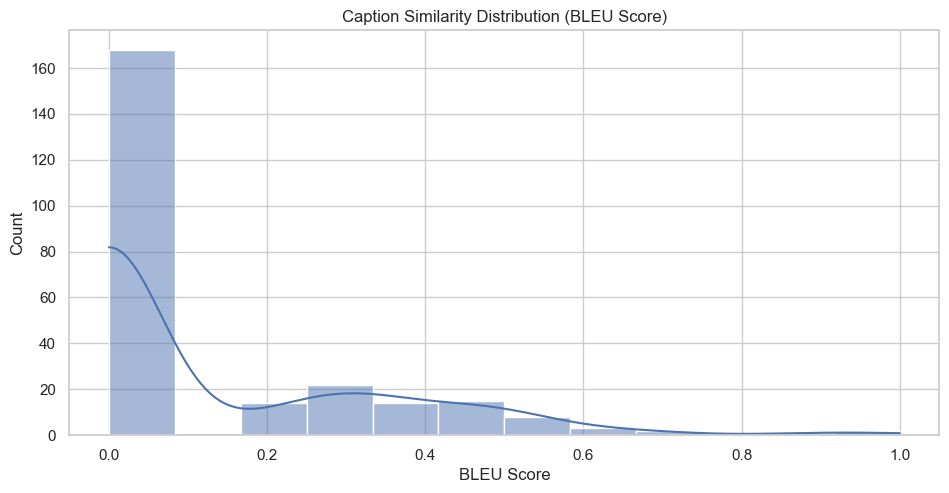

BLEU Score: min=0.0000, max=1.0000, mean=0.1282, median=0.0000


In [52]:
# Instead of using word_tokenize which requires punkt_tab, let's implement a simpler tokenization approach
import re
import string
from nltk.translate.bleu_score import sentence_bleu
import os
import time

# Define a simple word tokenizer function that doesn't require NLTK's punkt
def simple_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Replace punctuation with spaces
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    # Split on whitespace and filter out empty strings
    return [token for token in text.split() if token]

# Test the simple tokenizer
test_sentence = "This is a test sentence, with some punctuation!"
print(f"Simple tokenization test: {simple_tokenize(test_sentence)}")

# Calculate BLEU scores between captions for the same image (no tqdm)
def calculate_caption_similarity(dataset_split, num_samples=50):
    bleu_scores = []
    
    # Get a subset of examples using the take() method
    total = min(num_samples, len(dataset_split))
    print(f"Calculating similarity for {total} samples...")
    start_time = time.time()
    
    # Proper way to iterate through samples in a Hugging Face dataset
    samples = list(dataset_split.take(total))
    
    for i, example in enumerate(samples):
        if 'caption' in example:
            captions = example['caption']
            if isinstance(captions, list) and len(captions) >= 2:
                # For each caption, compare it to all other captions for the same image
                for j, caption in enumerate(captions):
                    try:
                        # Use our simple tokenizer instead of word_tokenize
                        reference_captions = [simple_tokenize(cap) for k, cap in enumerate(captions) if k != j]
                        candidate_caption = simple_tokenize(caption)
                        
                        # Calculate BLEU score
                        bleu = sentence_bleu(reference_captions, candidate_caption)
                        bleu_scores.append(bleu)
                    except Exception as e:
                        print(f"Error processing caption {j} for example {i}: {e}")
            
        # Report progress periodically
        if (i + 1) % 10 == 0 or i == total - 1:
            progress = (i + 1) / total * 100
            elapsed = time.time() - start_time
            print(f"Progress: {i+1}/{total} ({progress:.1f}%) - {elapsed:.1f}s elapsed")
    
    print(f"Similarity calculation complete. Total time: {time.time() - start_time:.1f}s")
    return bleu_scores

# Calculate BLEU scores for a smaller subset to save time
try:
    bleu_scores = calculate_caption_similarity(dataset[main_split], num_samples=50)
    
    if bleu_scores:
        # Plot BLEU score distribution
        plt.figure(figsize=(10, 5))
        sns.histplot(bleu_scores, kde=True)
        plt.title('Caption Similarity Distribution (BLEU Score)')
        plt.xlabel('BLEU Score')
        plt.show()
        
        # Print summary statistics
        print(f"BLEU Score: min={min(bleu_scores):.4f}, max={max(bleu_scores):.4f}, mean={np.mean(bleu_scores):.4f}, median={np.median(bleu_scores):.4f}")
    else:
        print("No BLEU scores calculated. Check that the dataset has multiple captions per image.")
except Exception as e:
    print(f"Error calculating similarity: {e}")
    print("Using a very basic comparison instead.")
    
    # If all else fails, try a very basic comparison (word overlap)
    def calculate_word_overlap(dataset_split, num_samples=10):
        overlap_scores = []
        samples = list(dataset_split.take(num_samples))
        
        for example in samples:
            if 'caption' in example and isinstance(example['caption'], list) and len(example['caption']) >= 2:
                captions = example['caption']
                for i, cap1 in enumerate(captions):
                    words1 = set(cap1.lower().split())
                    for j, cap2 in enumerate(captions):
                        if i < j:  # Only compare each pair once
                            words2 = set(cap2.lower().split())
                            if len(words1) > 0 and len(words2) > 0:
                                overlap = len(words1.intersection(words2)) / len(words1.union(words2))
                                overlap_scores.append(overlap)
        
        return overlap_scores
    
    # Try the simpler approach
    overlap_scores = calculate_word_overlap(dataset[main_split])
    if overlap_scores:
        plt.figure(figsize=(10, 5))
        sns.histplot(overlap_scores, kde=True)
        plt.title('Caption Similarity Distribution (Word Overlap)')
        plt.xlabel('Overlap Score (Jaccard Similarity)')
        plt.show()
        
        print(f"Word Overlap: min={min(overlap_scores):.4f}, max={max(overlap_scores):.4f}, mean={np.mean(overlap_scores):.4f}, median={np.median(overlap_scores):.4f}")

## Visual Features Analysis

Let's analyze some visual features of the images in the dataset.

Extracting features from 100 samples...
Progress: 10/100 (10.0%) - 0.1s elapsed
Progress: 20/100 (20.0%) - 0.2s elapsed
Progress: 30/100 (30.0%) - 0.3s elapsed
Progress: 40/100 (40.0%) - 0.4s elapsed
Progress: 50/100 (50.0%) - 0.4s elapsed
Progress: 60/100 (60.0%) - 0.5s elapsed
Progress: 30/100 (30.0%) - 0.3s elapsed
Progress: 40/100 (40.0%) - 0.4s elapsed
Progress: 50/100 (50.0%) - 0.4s elapsed
Progress: 60/100 (60.0%) - 0.5s elapsed
Progress: 70/100 (70.0%) - 0.6s elapsed
Progress: 80/100 (80.0%) - 0.8s elapsed
Progress: 70/100 (70.0%) - 0.6s elapsed
Progress: 80/100 (80.0%) - 0.8s elapsed
Progress: 90/100 (90.0%) - 1.0s elapsed
Progress: 100/100 (100.0%) - 1.1s elapsed
Feature extraction complete. Total time: 1.1s
Progress: 90/100 (90.0%) - 1.0s elapsed
Progress: 100/100 (100.0%) - 1.1s elapsed
Feature extraction complete. Total time: 1.1s


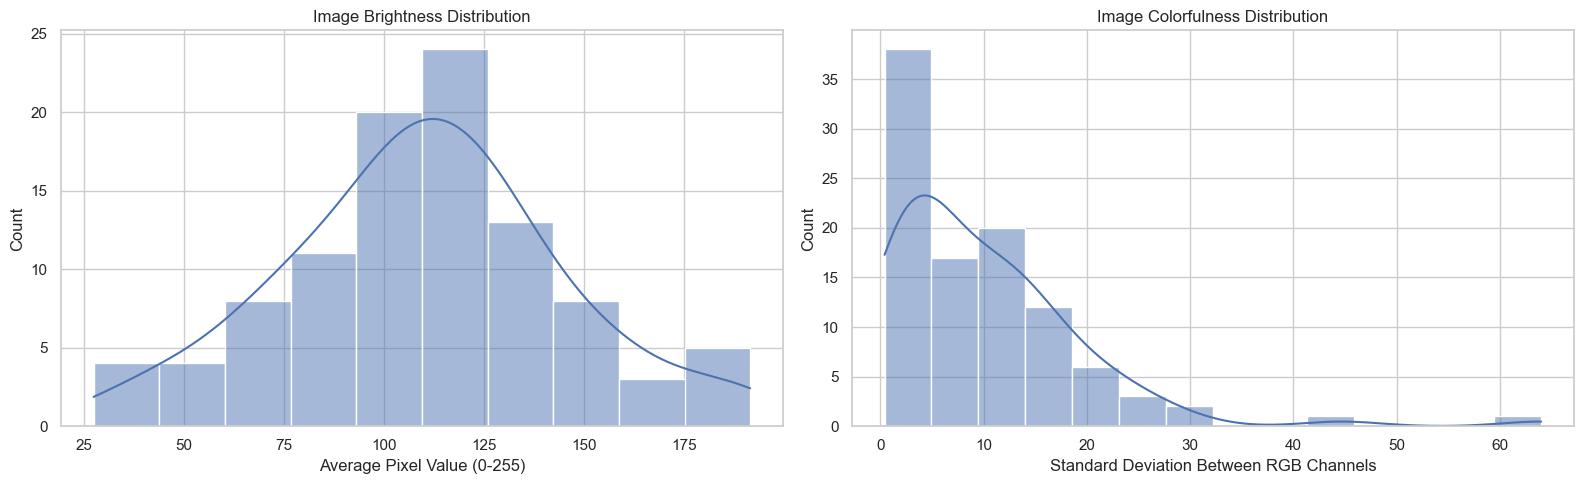

In [53]:
# Function to extract basic visual features (no tqdm)
def extract_visual_features(dataset, num_samples=100):
    brightness_values = []
    colorfulness_values = []
    
    # Sample random images
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    print(f"Extracting features from {len(indices)} samples...")
    start_time = time.time()
    
    for i, idx in enumerate(indices):
        img = dataset[idx]['image']
        img_array = np.array(img)
        
        # Calculate average brightness
        brightness = np.mean(img_array)
        brightness_values.append(brightness)
        
        # Calculate colorfulness (standard deviation across channels)
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # Check if it's RGB
            r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
            colorfulness = np.std([np.mean(r), np.mean(g), np.mean(b)])
            colorfulness_values.append(colorfulness)
        
        # Report progress every 10 images
        if (i + 1) % 10 == 0 or i == len(indices) - 1:
            progress = (i + 1) / len(indices) * 100
            elapsed = time.time() - start_time
            print(f"Progress: {i+1}/{len(indices)} ({progress:.1f}%) - {elapsed:.1f}s elapsed")
    
    print(f"Feature extraction complete. Total time: {time.time() - start_time:.1f}s")
    return brightness_values, colorfulness_values

# Extract features from a smaller subset
brightness_values, colorfulness_values = extract_visual_features(dataset[main_split], num_samples=100)

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(brightness_values, kde=True, ax=axes[0])
axes[0].set_title('Image Brightness Distribution')
axes[0].set_xlabel('Average Pixel Value (0-255)')

sns.histplot(colorfulness_values, kde=True, ax=axes[1])
axes[1].set_title('Image Colorfulness Distribution')
axes[1].set_xlabel('Standard Deviation Between RGB Channels')

plt.tight_layout()
plt.show()

## Correlation Between Image Features and Caption Length

Let's investigate if there's any correlation between image features and caption length.

Analyzing correlations across 100 samples...
Progress: 10/100 (10.0%) - 0.2s elapsed
Progress: 20/100 (20.0%) - 0.4s elapsed
Progress: 10/100 (10.0%) - 0.2s elapsed
Progress: 20/100 (20.0%) - 0.4s elapsed
Progress: 30/100 (30.0%) - 0.6s elapsed
Progress: 30/100 (30.0%) - 0.6s elapsed
Progress: 40/100 (40.0%) - 0.9s elapsed
Progress: 40/100 (40.0%) - 0.9s elapsed
Progress: 50/100 (50.0%) - 1.1s elapsed
Progress: 60/100 (60.0%) - 1.3s elapsed
Progress: 50/100 (50.0%) - 1.1s elapsed
Progress: 60/100 (60.0%) - 1.3s elapsed
Progress: 70/100 (70.0%) - 1.5s elapsed
Progress: 80/100 (80.0%) - 1.7s elapsed
Progress: 70/100 (70.0%) - 1.5s elapsed
Progress: 80/100 (80.0%) - 1.7s elapsed
Progress: 90/100 (90.0%) - 2.1s elapsed
Progress: 90/100 (90.0%) - 2.1s elapsed
Progress: 100/100 (100.0%) - 2.3s elapsed
Correlation analysis complete. Total time: 2.3s
Progress: 100/100 (100.0%) - 2.3s elapsed
Correlation analysis complete. Total time: 2.3s


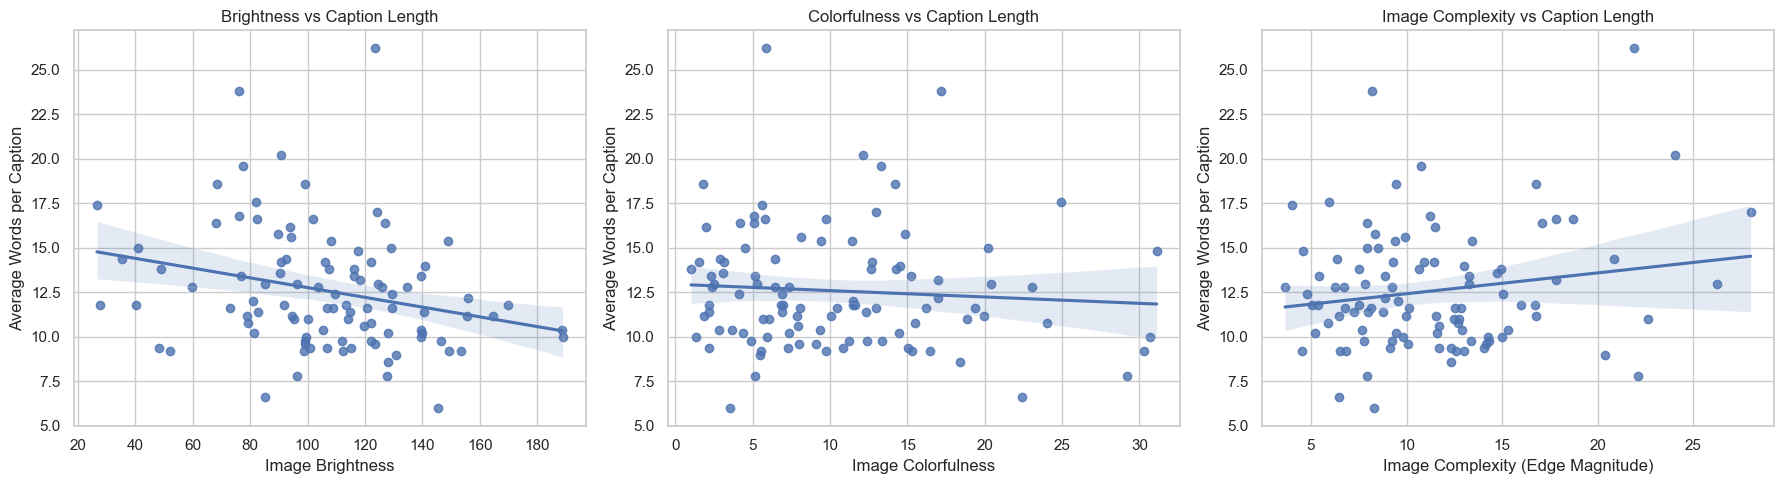

Correlation with caption length:
brightness     -0.263439
colorfulness   -0.075900
complexity      0.174441
Name: caption_length, dtype: float64


In [54]:
# Function to collect both image features and caption lengths (no tqdm)
def analyze_image_caption_correlation(dataset, num_samples=100):
    data = []
    
    # Sample random images
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    print(f"Analyzing correlations across {len(indices)} samples...")
    start_time = time.time()
    
    for i, idx in enumerate(indices):
        example = dataset[idx]
        img = example['image']
        captions = example['caption']
        
        img_array = np.array(img)
        
        # Calculate average brightness
        brightness = np.mean(img_array)
        
        # Calculate colorfulness
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # Check if it's RGB
            r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
            colorfulness = np.std([np.mean(r), np.mean(g), np.mean(b)])
        else:
            colorfulness = 0
            
        # Calculate image complexity (using edge detection as a proxy)
        if len(img_array.shape) == 3:
            gray = np.mean(img_array, axis=2)  # Convert to grayscale
            dx = np.gradient(gray, axis=0)
            dy = np.gradient(gray, axis=1)
            complexity = np.mean(np.sqrt(dx**2 + dy**2))
        else:
            complexity = 0
            
        # Calculate average caption length
        avg_caption_length = np.mean([len(caption.split()) for caption in captions])
        
        data.append({
            'brightness': brightness,
            'colorfulness': colorfulness,
            'complexity': complexity,
            'caption_length': avg_caption_length
        })
        
        # Report progress every 10 images
        if (i + 1) % 10 == 0 or i == len(indices) - 1:
            progress = (i + 1) / len(indices) * 100
            elapsed = time.time() - start_time
            print(f"Progress: {i+1}/{len(indices)} ({progress:.1f}%) - {elapsed:.1f}s elapsed")
    
    print(f"Correlation analysis complete. Total time: {time.time() - start_time:.1f}s")
    return pd.DataFrame(data)

# Collect data for correlation analysis
correlation_df = analyze_image_caption_correlation(dataset[main_split], num_samples=100)

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(x='brightness', y='caption_length', data=correlation_df, ax=axes[0])
axes[0].set_title('Brightness vs Caption Length')
axes[0].set_xlabel('Image Brightness')
axes[0].set_ylabel('Average Words per Caption')

sns.regplot(x='colorfulness', y='caption_length', data=correlation_df, ax=axes[1])
axes[1].set_title('Colorfulness vs Caption Length')
axes[1].set_xlabel('Image Colorfulness')
axes[1].set_ylabel('Average Words per Caption')

sns.regplot(x='complexity', y='caption_length', data=correlation_df, ax=axes[2])
axes[2].set_title('Image Complexity vs Caption Length')
axes[2].set_xlabel('Image Complexity (Edge Magnitude)')
axes[2].set_ylabel('Average Words per Caption')

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
correlation_matrix = correlation_df.corr()
print("Correlation with caption length:")
print(correlation_matrix['caption_length'].drop('caption_length'))

## Summary and Conclusions

In this notebook, we performed an exploratory data analysis of the Flickr30k dataset from Hugging Face. Here's a summary of our findings:

1. **Dataset Structure**:
   - The dataset consists of images paired with multiple descriptive captions.
   - Each image typically has 5 different captions providing varied descriptions.

2. **Image Analysis**:
   - We analyzed the distribution of image sizes and aspect ratios.
   - We explored basic visual features like brightness and colorfulness.

3. **Caption Analysis**:
   - We examined caption lengths (in words and characters).
   - We identified the most common words used in the captions.
   - We analyzed the similarity between different captions for the same image.

4. **Correlation Analysis**:
   - We investigated potential relationships between image features (brightness, colorfulness, complexity) and caption length.

These insights provide a solid understanding of the Flickr30k dataset's characteristics, which is valuable for building and evaluating image captioning models.

## Next Steps

Here are some potential next steps for further analysis or model development:

1. **Advanced Feature Extraction**: Use pre-trained CNNs to extract more meaningful image features.
2. **Named Entity Recognition**: Analyze the types of objects, people, and places mentioned in the captions.
3. **Caption Diversity Analysis**: More detailed analysis of how diverse the captions are for each image.
4. **Model Development**: Build and train an image captioning model using the insights from this EDA.
5. **Bias Analysis**: Examine potential biases in the dataset's images and captions.